# Medical Cost Prediction

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, mean_squared_error

### Explore data

We will explore and visualize our data with various beuatiful graphs.





In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
len(df)

1338

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [7]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [6]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

The data is not fully numeric, this is bad because the model cannot read patterns if the data is not in a numeric format. We can use `pd.replace()` and `pd.get_dummies()` to turn the data into a numeric format.

In [11]:
df["sex"].replace({"male": 0, "female": 1}, inplace=True) # Male: 0, Female: 1
df["smoker"].replace({"yes": 1, "no": 0}, inplace=True) # Yes: 1, No: 0

df = pd.get_dummies(df) # divide regions column into four different column with binary labels
df.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,1,27.900,0,1,16884.92400,0,0,0,1
1,18,0,33.770,1,0,1725.55230,0,0,1,0
2,28,0,33.000,3,0,4449.46200,0,0,1,0
3,33,0,22.705,0,0,21984.47061,0,1,0,0
4,32,0,28.880,0,0,3866.85520,0,1,0,0


Now that our data has been fixed, let's visualize it!

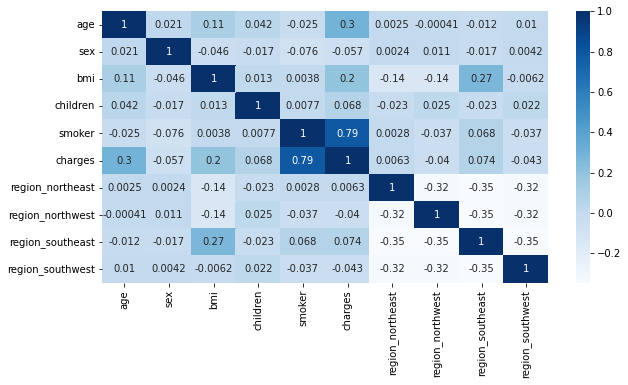

In [15]:
plt.figure(figsize=(10, 5))
sns.heatmap(df.corr(), annot=True, cmap="Blues"); # A heat map represents these coefficients to visualize the strength of correlation among variables.

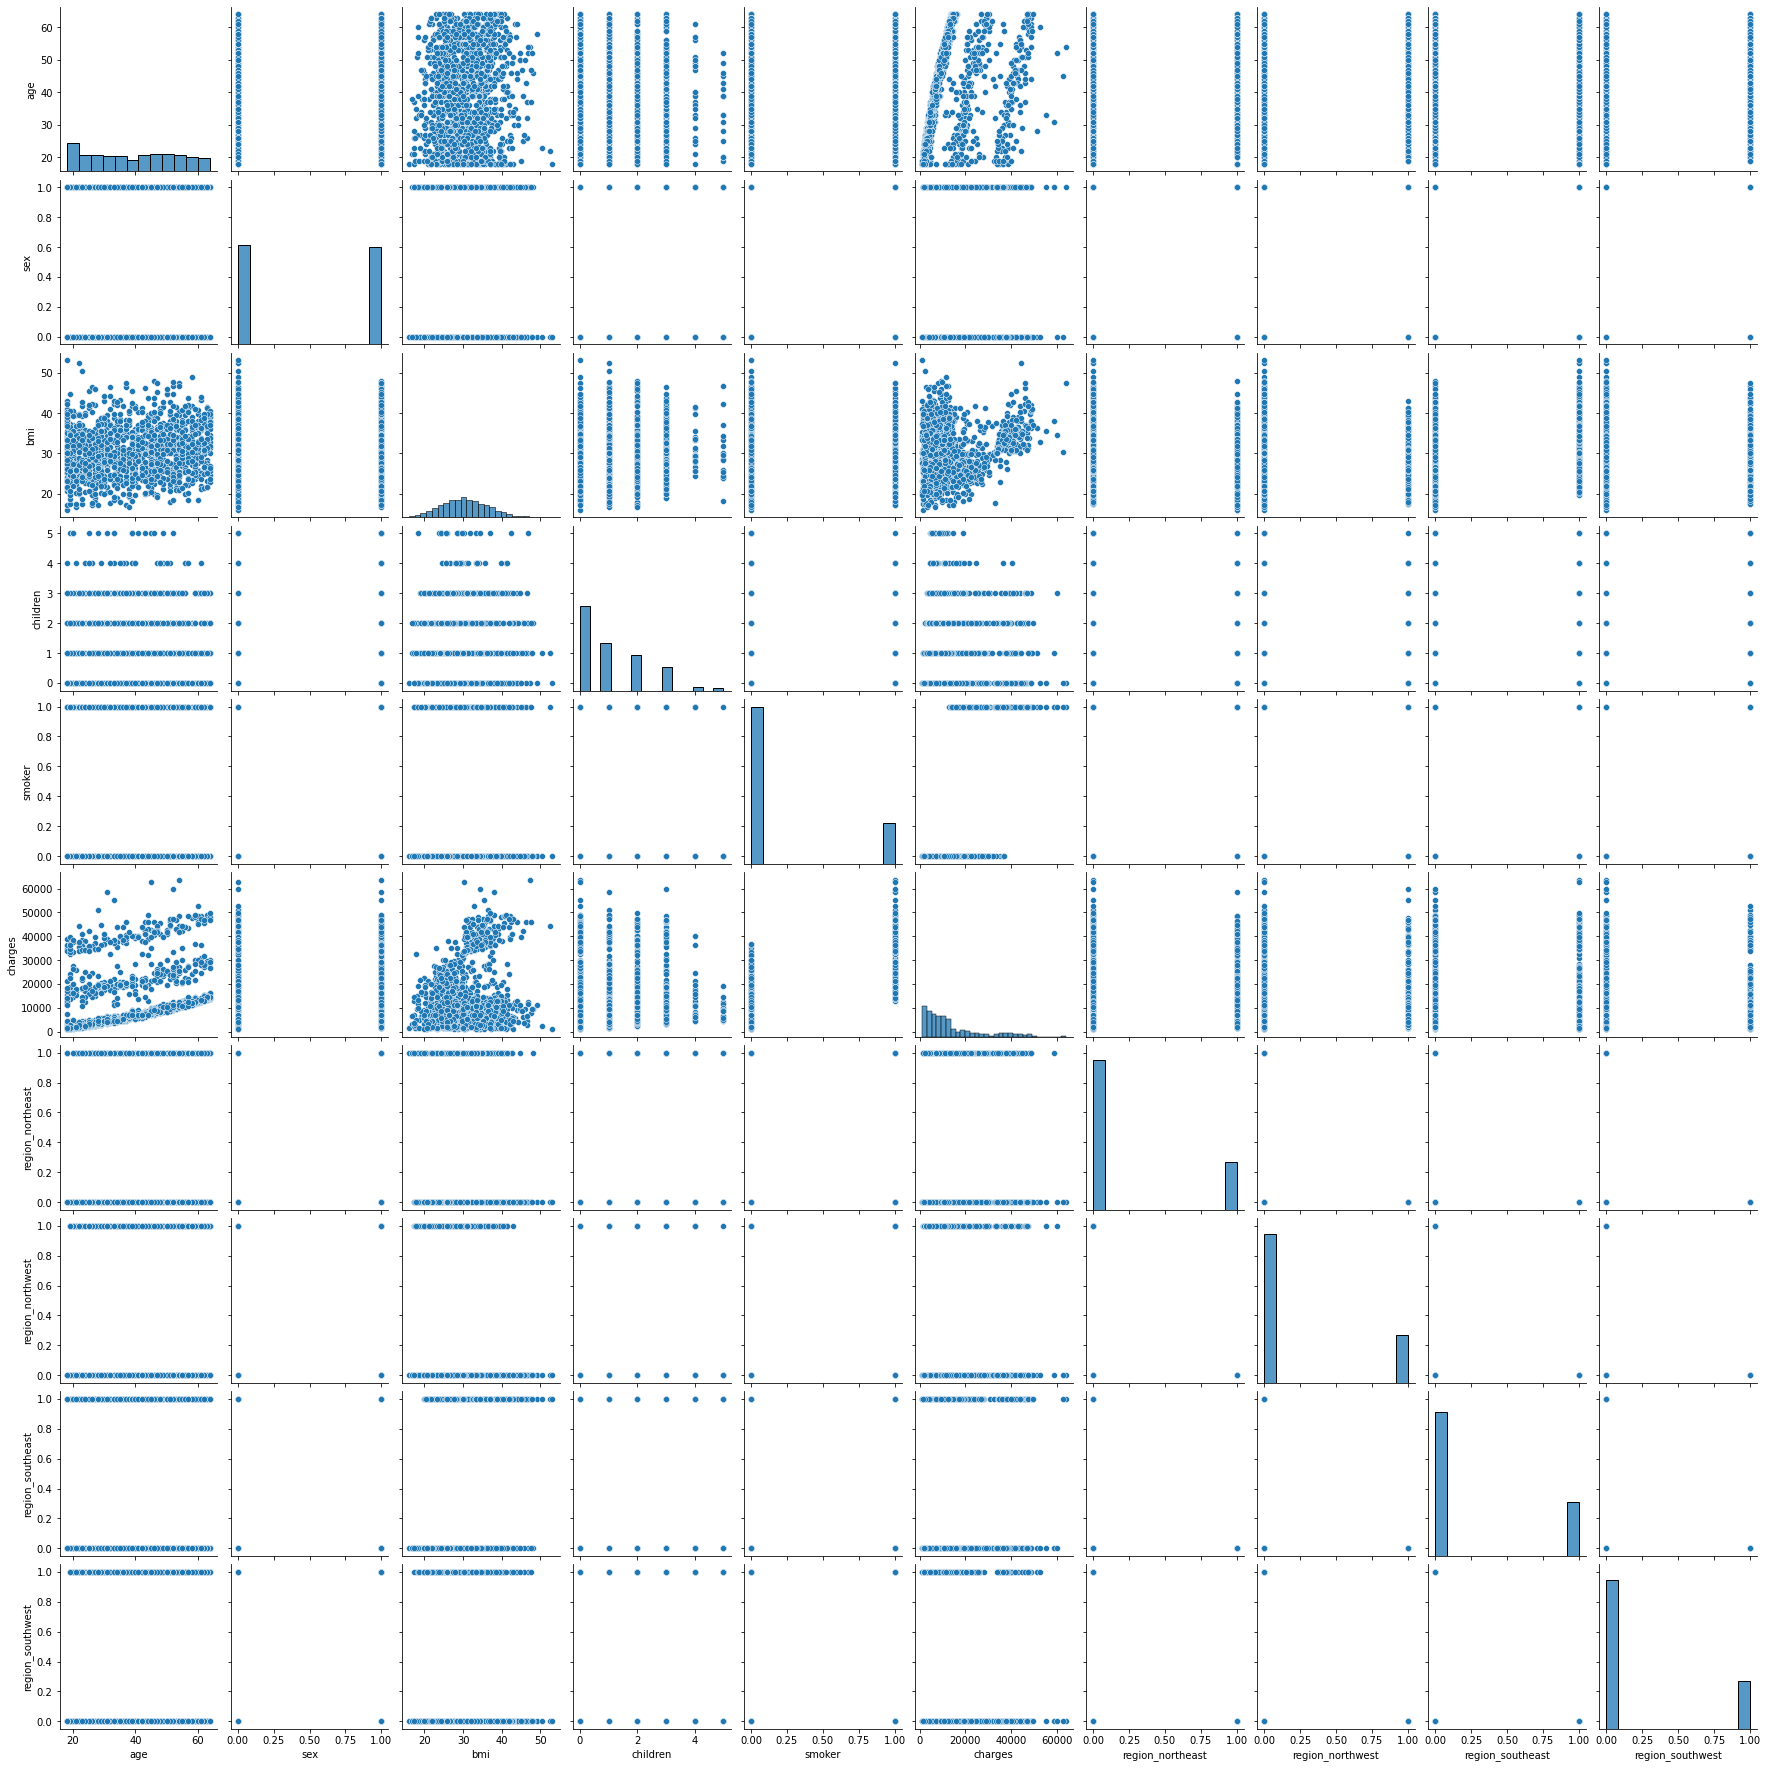

In [19]:
sns.pairplot(df);

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


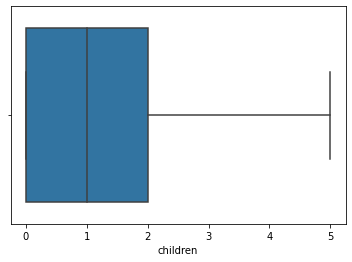

In [24]:
sns.boxplot(df.children);

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


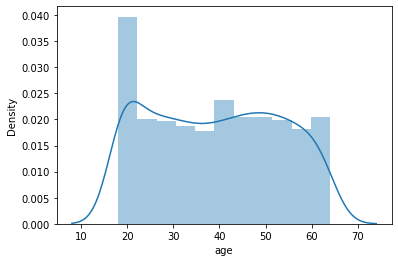

In [25]:
sns.distplot(df["age"]);

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


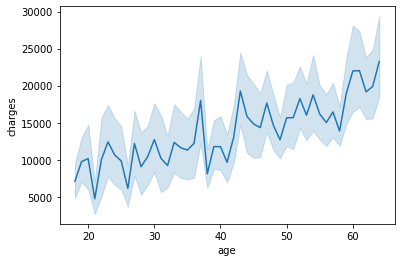

In [27]:
sns.lineplot(df["age"], df["charges"]);

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


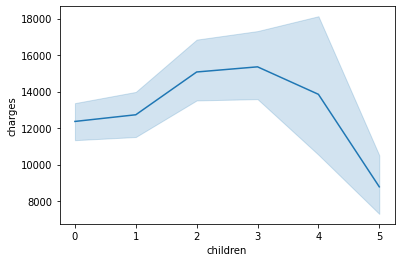

In [30]:
sns.lineplot(df["children"], df["charges"]);

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


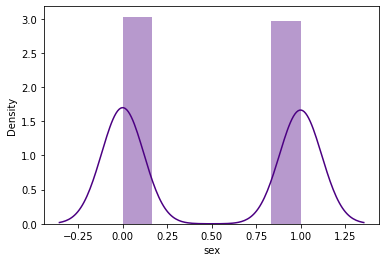

In [32]:
sns.distplot(df["sex"], color="indigo");

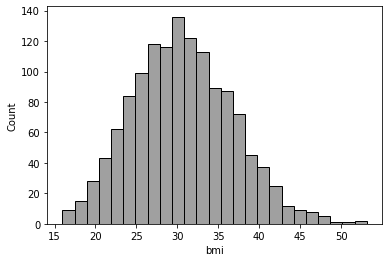

In [34]:
sns.histplot(df["bmi"], color="grey");

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


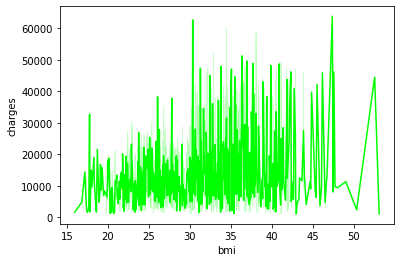

In [36]:
sns.lineplot(df["bmi"], df["charges"], color="lime");

### Building a Simple Model

We will now build a simple model using LinearRegression. LinearRegression is used to predict a dependent variable (label) based on the value of independent variables (features).

In [38]:
# Split Data in X and y

X = df.drop("charges", axis=1) # X: all columns except charges, independant variables
y = df["charges"] # y: charges colums, dependent variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Training dzta: 80% of the dataset; Testing Data: 20% of the dataset

len(X_train), len(X_test)

(1070, 268)

In [40]:
# Create simple LinearRegression model

simple_model = LinearRegression()
simple_model.fit(X_train, y_train)

LinearRegression()

In [45]:
def model_report(y_test, y_pred):
    print(f"Accuracy: {simple_model.score(X_test, y_test) * 100:.2f}%")
    print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
    print(f"MSE: {mean_squared_error(y_test, y_pred)}")
    print(f"R2: {r2_score(y_test, y_pred)}")

In [46]:
y_pred = simple_model.predict(X_test)

model_report(y_test, y_pred)

Accuracy: 78.36%
MAE: 4181.194473753642
MSE: 33596915.85136146
R2: 0.7835929767120723


In [47]:
np.mean(df["charges"])

13270.422265141257

Excellent, we are off to a good start. Although a better MAE will be needed as the mean of the dependent variable is $13270. Our model's predicted value on average is 4181 dollars away from the actual value.

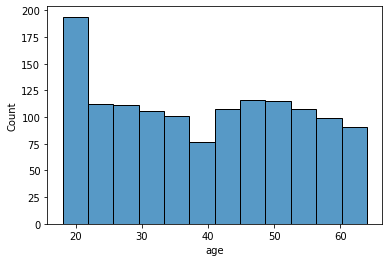

In [75]:
sns.histplot(df["age"]);

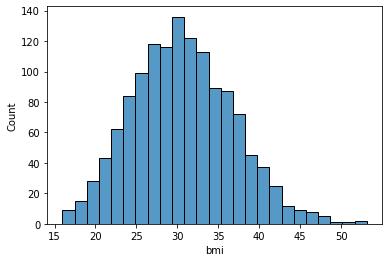

In [76]:
sns.histplot(df["bmi"]);

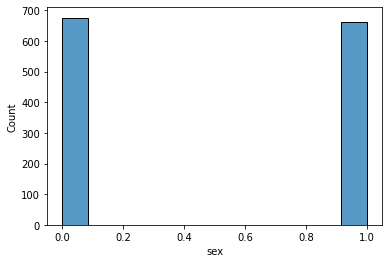

In [77]:
sns.histplot(df["sex"]);

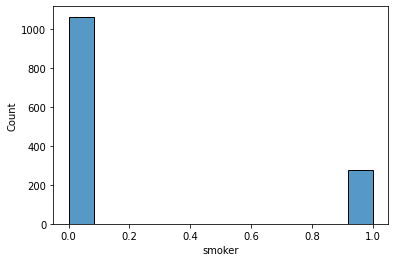

In [78]:
sns.histplot(df["smoker"]);

### Preprocessing Data

Let's preprocess our data with `MinMaxScaler()`. It will normalize our dataset. The goal is to change the values in the numeric columns to follow a common scale, thus creating a better model.

In [80]:
normalizer = MinMaxScaler()
normalizer.fit(X_train)

X_train_normal = normalizer.transform(X_train)
X_test_normal = normalizer.transform(X_test)

pd.DataFrame(X_train_normal[:10])

,0,1,2,3,4,5,6,7,8
0,0.608696,1.0,0.107345,0.4,0.0,0.0,1.0,0.0,0.0
1,0.630435,1.0,0.224913,0.0,0.0,1.0,0.0,0.0,0.0
2,0.739130,1.0,0.239440,0.0,0.0,0.0,0.0,1.0,0.0
3,0.456522,1.0,0.493947,1.0,0.0,0.0,0.0,1.0,0.0
4,0.782609,1.0,0.148238,0.6,0.0,0.0,1.0,0.0,0.0
5,0.978261,0.0,0.686306,0.0,0.0,0.0,0.0,1.0,0.0
6,0.086957,1.0,0.224374,0.0,0.0,0.0,0.0,0.0,1.0
7,0.000000,0.0,0.150794,0.0,1.0,1.0,0.0,0.0,0.0
8,0.478261,0.0,0.679849,0.2,0.0,1.0,0.0,0.0,0.0
9,0.413043,0.0,0.490718,0.2,1.0,1.0,0.0,0.0,0.0


In [81]:
model_normal = LinearRegression()
model_normal.fit(X_train_normal, y_train)

LinearRegression()

In [83]:
y_pred_normal = model_normal.predict(X_test_normal)

model_report(y_test, y_pred_normal)

Accuracy: 78.36%
MAE: 4181.49162033209
MSE: 33566958.79026423
R2: 0.7837859384246053


### Preprocessing Data 2

For some reason, normalization was not effective. Let's use `StandardScaler()` to standardize the data.

Standardization is another scaling technique where the values are centered around the mean with a unit standard deviation. This means that the mean of the attribute becomes zero and the resultant distribution has a unit standard deviation.

In [89]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

pd.DataFrame(X_train_scaled[:10])

,0,1,2,3,4,5,6,7,8
0,0.472227,1.024602,-1.756525,0.734336,-0.508747,-0.576631,1.783168,-0.599661,-0.572314
1,0.543313,1.024602,-1.033082,-0.911192,-0.508747,1.734212,-0.560800,-0.599661,-0.572314
2,0.898745,1.024602,-0.943687,-0.911192,-0.508747,-0.576631,-0.560800,1.667609,-0.572314
3,-0.025379,1.024602,0.622393,3.202629,-0.508747,-0.576631,-0.560800,1.667609,-0.572314
4,1.040918,1.024602,-1.504893,1.557100,-0.508747,-0.576631,1.783168,-0.599661,-0.572314
5,1.680696,-0.975989,1.806058,-0.911192,-0.508747,-0.576631,-0.560800,1.667609,-0.572314
6,-1.233848,1.024602,-1.036393,-0.911192,-0.508747,-0.576631,-0.560800,-0.599661,1.747292
7,-1.518194,-0.975989,-1.489166,-0.911192,1.965613,1.734212,-0.560800,-0.599661,-0.572314
8,0.045708,-0.975989,1.766326,-0.088428,-0.508747,1.734212,-0.560800,-0.599661,-0.572314
9,-0.167551,-0.975989,0.602527,-0.088428,1.965613,1.734212,-0.560800,-0.599661,-0.572314


In [90]:
model_scaled = LinearRegression()
model_scaled.fit(X_train_scaled, y_train)

LinearRegression()

In [91]:
y_pred_scaled = model_scaled.predict(X_test_scaled)

model_report(y_test, y_pred_scaled)

Accuracy: 78.36%
MAE: 4290.830206249954
MSE: 34387098.55152489
R2: 0.7785031914843887


### Preprocessing Data 3

Well, both of the previous scalers did not do so well. Let's try `PolynomialFeatures()`.
Polynomial features are those features created by raising existing features to an exponent.

In [92]:
poly = PolynomialFeatures()
poly.fit(X_train)

X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)

In [93]:
model_poly = LinearRegression()
model_poly.fit(X_train_poly, y_train)

LinearRegression()

In [94]:
y_pred_poly = model_poly.predict(X_test_poly)

model_report(y_test, y_pred_poly)

Accuracy: 78.36%
MAE: 2764.6485288208955
MSE: 20940847.89046858
R2: 0.8651142093771103
